In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statistics

from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
from funcoes import calcular_centro_gravidade

# Primeiros passos

Vamos descobrir como ler um arquivo de audio como um sinal, ou seja, uma sequência de números que correspondem às intensidades.

Vamos tentar visualizar o espectro de frequência e o espectrograma para poder observar como as faixas de áudio são.

### Lendo arquivo de audio

"assobio_agudo.wav" é um arquivo de áudio que eu gravei fazendo assobio agudo

In [2]:
assobio = "audios/assobio_agudo.wav"
taxa_amostragem, dados = wavfile.read(assobio)

print ("Taxa de amostragem do arquivo de audio:", taxa_amostragem)
print ("Número de amostras:", dados.shape)

Taxa de amostragem do arquivo de audio: 8000
Número de amostras: (38000,)


### Visualizando o audio

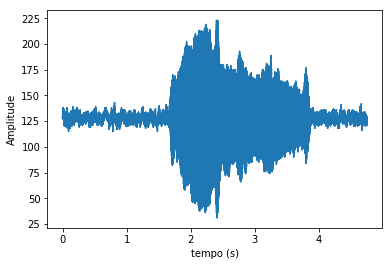

In [3]:
# tempos são os números das amostras, começando de 0
tempos = np.arange(0, dados.shape[0], 1)
# agora, tempos passa a ser o tempo de cada amostra
tempos = (tempos / taxa_amostragem)

plt.plot(tempos, dados)
plt.ylabel("Amplitude")
plt.xlabel("tempo (s)")
plt.show()

Dá pra notar exatamente onde é apenas ruído de ambiente, e quando foi que eu bati a palma

### Analisando na frequência

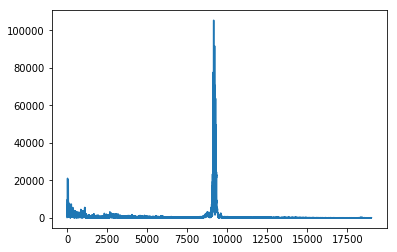

In [4]:
dados_frequencia = fft(dados)
plt.plot(np.abs(dados_frequencia[1:dados.shape[0]//2]))
plt.show()

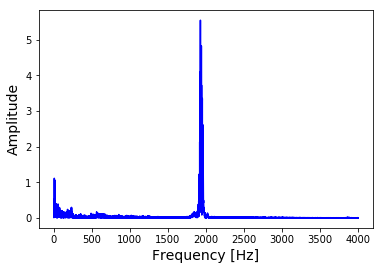

In [5]:
def get_fft_values(sampling_rate, data):
    size = data.shape[0]
    f_values = np.linspace(0.0, sampling_rate/2.0, size//2)
    fft_values_ = fft(data)
    fft_values = 2.0/size * np.abs(fft_values_[0:size//2])
    return f_values, fft_values

f_values, fft_values = get_fft_values(taxa_amostragem, dados)
 
plt.plot(f_values[1:], fft_values[1:], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.show()

####  Observação
Quando formos plotar o espectro de frequência, devemos descartar o que estiver na origem (frequência = 0Hz).

Isso é porque a transformada de Fourrier é para sinais periódicos. Quando a aplicamos para um sinal não periódico (que tem frequência zero), a transformada dá um negócio muito forte na frequência DC.

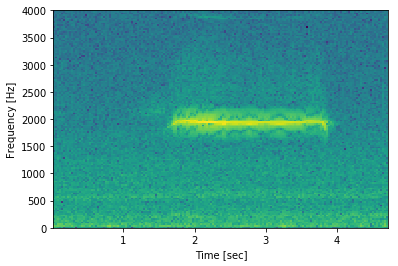

In [6]:
frequencies, times, spectrogram = signal.spectrogram(dados, taxa_amostragem)

plt.pcolormesh(times, frequencies, np.log(spectrogram))
# plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### Iterando nos arquivos de áudio do diretório

Para cada arquivo de áudio, vamos plotá-lo no tempo, depois fazer a FFT e plotá-lo na frequência, e então plotar seu espectograma.

Pode ser interessante ver tudo isso lado a lado, talvêz dê alguma ideia

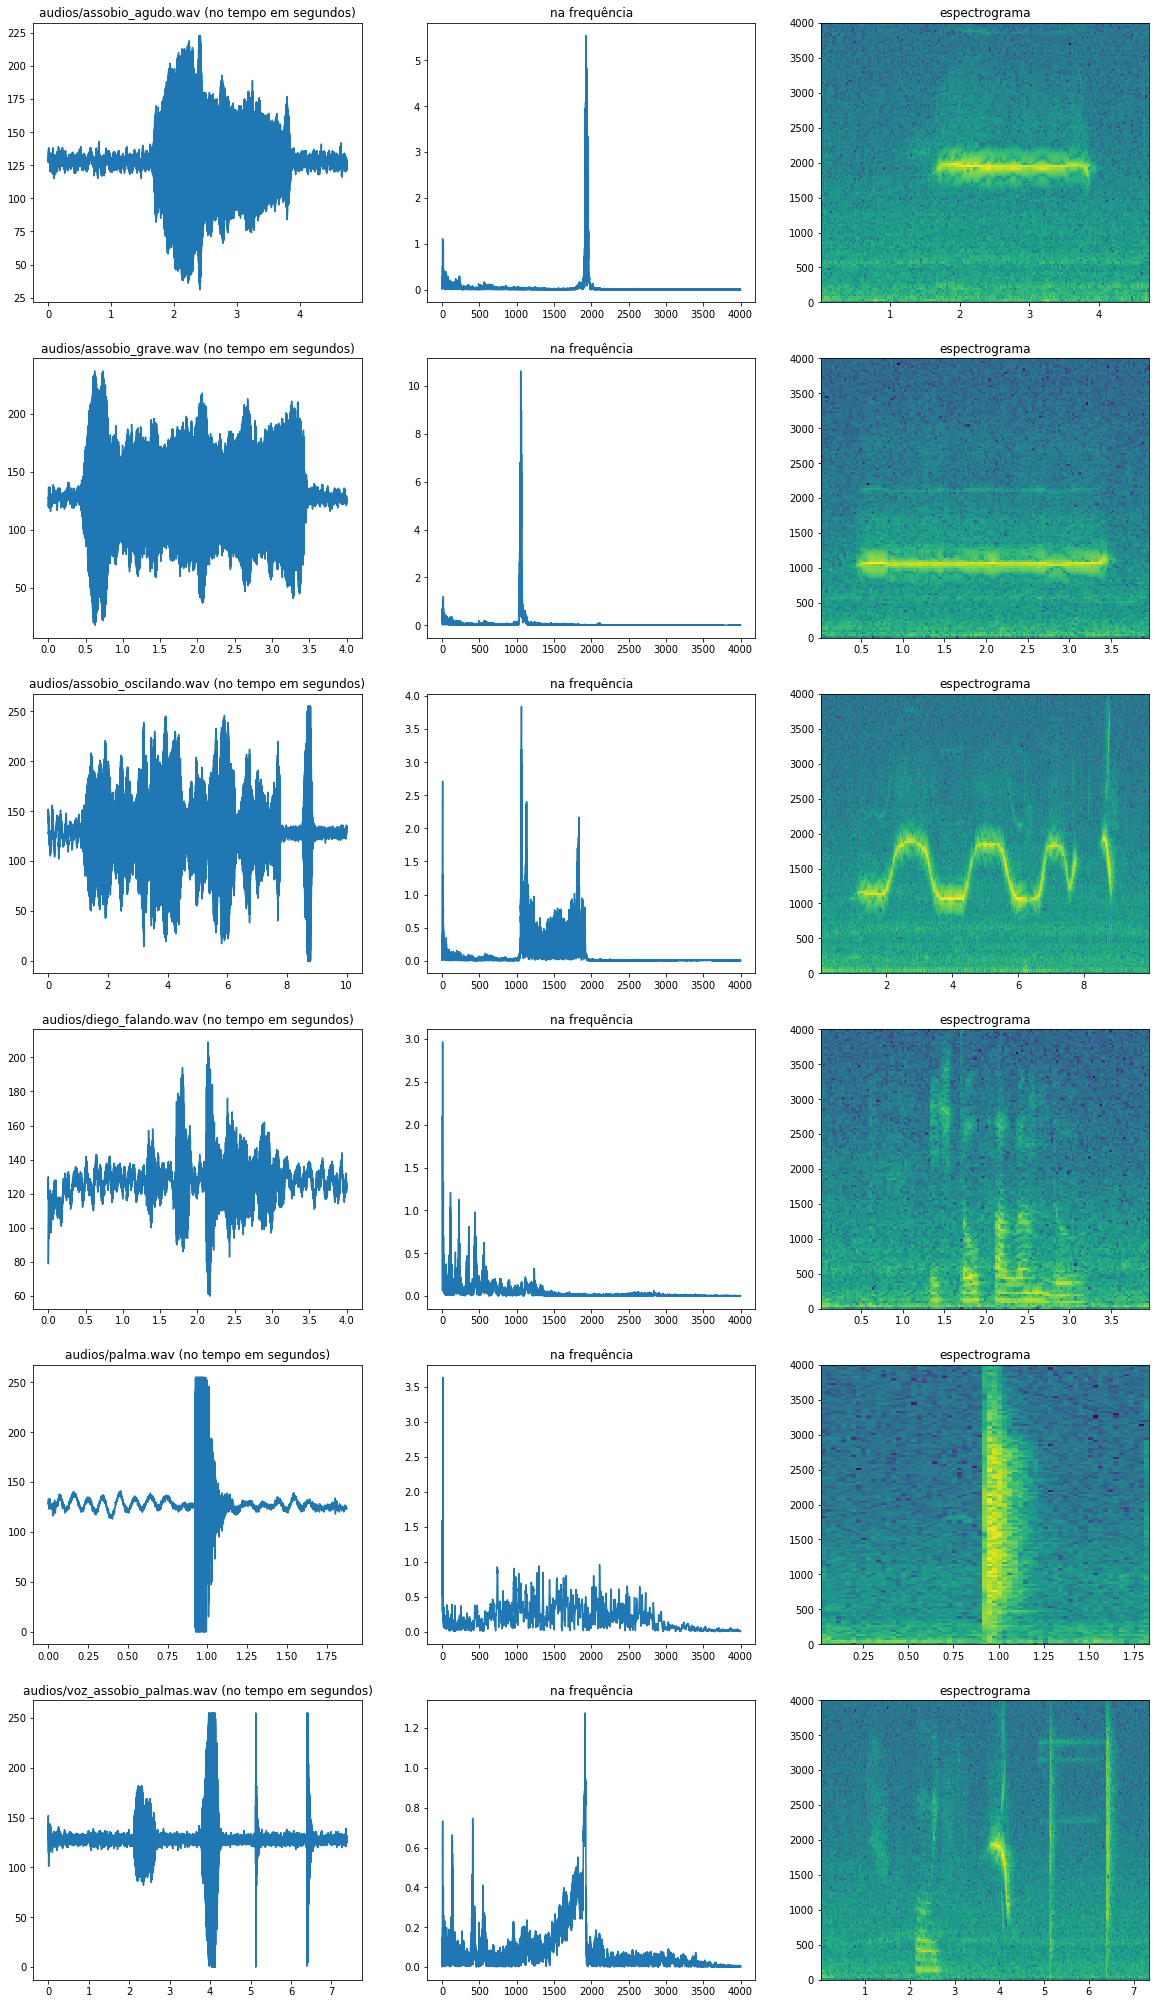

In [7]:
# Preparando os arquivos que serão lidos
dir_audios = "audios"
arquivos_audio = [os.path.join(dir_audios, arq_audio) for arq_audio in os.listdir(dir_audios)]

# Preparando o gráfico com 3 colunas e n linhas: para cada audio,
# vamos plotar no tempo, na frequência e seu espectrograma
qtd_audios = len(arquivos_audio)
altura_por_grafico = 6
figura, eixos = plt.subplots(qtd_audios, 3, figsize=(20,altura_por_grafico * qtd_audios))

for i, arq_audio in enumerate(arquivos_audio):
    # ler arquivo de audio
    taxa_amostragem, dados = wavfile.read(arq_audio)
    
    """
    NO TEMPO
    """    
    
    # tempos são os números das amostras, começando de 0
    tempos = np.arange(0, dados.shape[0], 1)
    # agora, tempos passa a ser o tempo de cada amostra
    tempos = (tempos / taxa_amostragem)
    
    grafico = eixos[i][0]
    grafico.plot(tempos, dados)
    grafico.set_title(arq_audio + " (no tempo em segundos)")
    
    """
    NA FREQUÊNCIA
    """
    f_values, fft_values = get_fft_values(taxa_amostragem, dados)

    grafico = eixos[i][1]
    grafico.plot(f_values[1:], fft_values[1:])
    grafico.set_title("na frequência")
    
    """
    ESPECTROGRAMA
    """
    
    frequencies, times, spectrogram = signal.spectrogram(dados, taxa_amostragem)
    
    grafico = eixos[i][2]
    grafico.pcolormesh(times, frequencies, np.log(spectrogram))
    grafico.set_title("espectrograma")
    
plt.show()

# Data engineering

A partir de agora, vamos tentar realmente produzir um conjunto de dados sobre o qual podemos realizar alguma análise.

Vamos tentar fazer uma forma organizada de ler os arquivos, cada um com sua classe, e programar a extração de features desses arquivos.

No final, vamos tentar fazer alguma visualização de dados, na esperança de encontrar algum insight.

## Extração de features

Vamos escrever as etapas de extração de features agora.

Isso será feito de um jeito que seja fácil acrescentar ou remover alguma função específica.

Toda função que dê origem a uma feature começa com 'f_'. Isso serve pra eu poder facilmente listar todas funções destinadas a esse propósito.

Todas funções devem receber apenas um parâmetro: os dados no domínio do tempo, que é um np.array.

In [8]:
# Toda função que analisar o espectro de frequência vai 
# ignorar as frequências abaixo de corte_passa_altas
corte_passa_altas = 300

TAXA_AMOSTRAGEM = 8000

def dados_na_frequencia(dados):
    """
    Todas funções que analisarem os dados no domínio da frequência
    irão puxar os dados daqui. Isso serve pra garantir que todas estão
    analisando a mesma coisa, mesmo que escolhamos outro fitro de 
    passa-altas ou qualquer coisa
    """
    x, y = get_fft_values(TAXA_AMOSTRAGEM, dados)
    
    # setar y = 0 para todo x < corte_passa_altas
    y = np.array([y[i] if x[i] > corte_passa_altas else 0 for i in range(len(x))])
    
    return x, y
    

def f_media(dados):
    """
    Calcula a média no eixo y dos dados.
    """
    x, y = dados_na_frequencia(dados)
    
    return statistics.mean(y)

def f_centro_gravidade(dados):
    """
    Recebe os dados e retorna o centro de gravidade dos mesmos.
    """
    x, y = dados_na_frequencia(dados)
    
    return calcular_centro_gravidade(x, y)
    
def f_mediana(dados):
    """
    Calcula a mediana no eixo y dos dados.
    """
    x, y = dados_na_frequencia(dados)
    
    return statistics.median(y)

def f_percentil75(dados):
    """
    Calcula o percentil 75 no eixo y dos dados.
    """
    x, y = dados_na_frequencia(dados)
    
    return np.percentile(y, 75)

def f_percentil90(dados):
    """
    Calcula o percentil 90 no eixo y dos dados.
    """
    x, y = dados_na_frequencia(dados)
    
    return np.percentile(y, 90)

def f_percentil99(dados):
    """
    Calcula o percentil 99 no eixo y dos dados.
    """
    x, y = dados_na_frequencia(dados)
    
    return np.percentile(y, 99)
    

extratores_disponiveis = [f for f in dir() if f.startswith('f_')]
# pegar o maior nome de extrator
maior_nome = max([len(nome) for nome in extratores_disponiveis])

print("Extratores de features disponíveis:")
for i, extrator in enumerate(extratores_disponiveis):
    # printar justificado
    print(extrator.ljust(maior_nome + 3), end='')
    if i % 2 == 0 and i > 0:
        # quebrar linha de vez em quando
        print()

Extratores de features disponíveis:
f_centro_gravidade   f_media              f_mediana            
f_percentil75        f_percentil90        
f_percentil99        f_values             


### Aplicando os extratores

In [22]:
# onde está as pastas com os áudios separados por classe
raiz = 'dataset'

# quais extratores de features queremos aplicar

extratores = [
    f_media,
    f_centro_gravidade,
#     f_mediana,
#     f_percentil75,
#     f_percentil90,
    f_percentil99
]

dados_extraidos = []

for classe in os.listdir(raiz):
    for nome in os.listdir(os.path.join(raiz, classe)):

        arquivo = os.path.join(raiz, classe, nome)
        amostragem, dados = wavfile.read(arquivo)
        
        assert amostragem == TAXA_AMOSTRAGEM
        
        dado = {f.__name__: f(dados) for f in extratores}
        dado['classe'] = classe
        dado['nome'] = nome
        
        dados_extraidos.append(dado)

#### Associar cada classe a um número:
um índice de uma lista

In [26]:
classes_extraidas = set([d['classe'] for d in dados_extraidos])

classes_extraidas = {c:i for i,c in enumerate(classes_extraidas)}
classes_extraidas

{'assobio_agudo': 0, 'palmas': 1, 'assobio_grave': 2}

In [27]:
for dado in dados_extraidos:
    dado['classe'] = classes_extraidas[dado['classe']]

### Dando uma olhada na tabela

In [28]:
import pandas as pd

tabela = pd.DataFrame(dados_extraidos)

tabela.head()

,classe,f_centro_gravidade,f_media,f_percentil99,nome
0,0,1744.925171,0.047517,1.067041,assobio_agudo-1.wav
1,0,1794.176401,0.053057,1.451006,assobio_agudo-10.wav
2,0,1808.564724,0.059772,1.531464,assobio_agudo-2.wav
3,0,1787.310829,0.050345,0.996071,assobio_agudo-3.wav
4,0,1746.282903,0.052391,1.252594,assobio_agudo-4.wav


#### Pós-processando a tabela

trocando a classe por valores numéricos, ignorando o nome...

In [29]:
# ignorando o nome
tabela = tabela.loc[:, tabela.columns != 'nome']
tabela.head()

,classe,f_centro_gravidade,f_media,f_percentil99
0,0,1744.925171,0.047517,1.067041
1,0,1794.176401,0.053057,1.451006
2,0,1808.564724,0.059772,1.531464
3,0,1787.310829,0.050345,0.996071
4,0,1746.282903,0.052391,1.252594


### Seleção de features

Primeiro, vamos fazer um pairplot pra ver se já tem alguma relação logo de cara, relembrando as classes:

In [30]:
classes_extraidas

{'assobio_agudo': 0, 'palmas': 1, 'assobio_grave': 2}

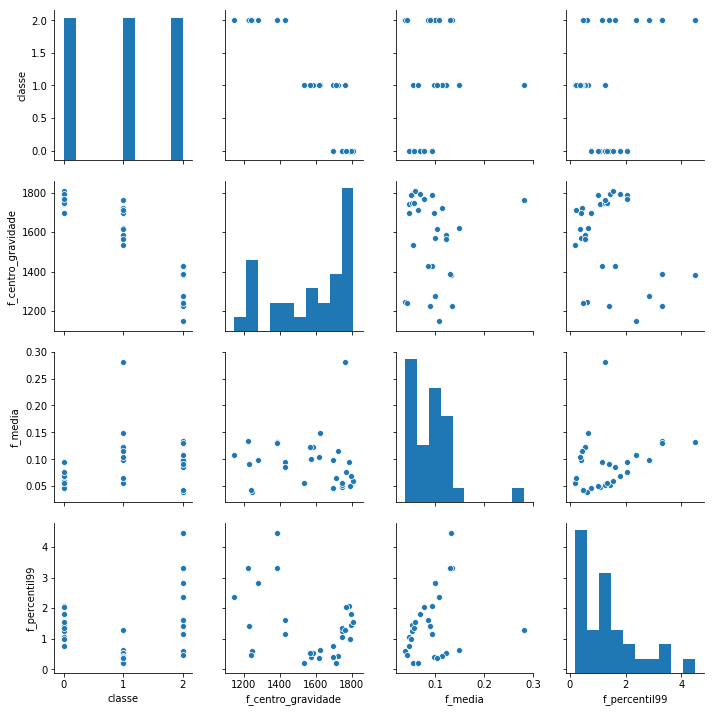

In [31]:
sns.pairplot(tabela)

Pra ficar melhor de ver, vamos plotar de um jeito que dê pra perceber as classes:

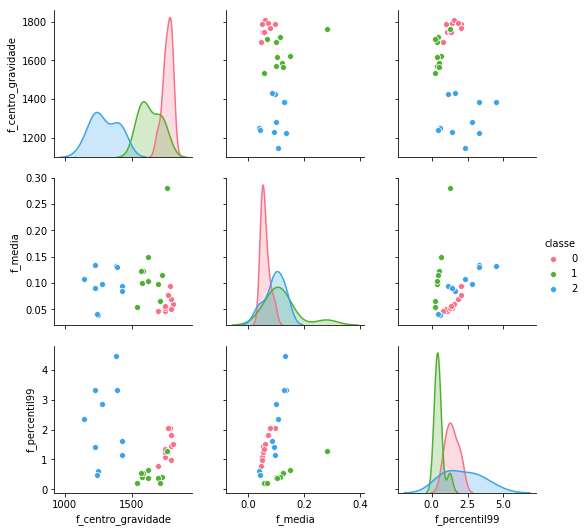

In [43]:
# Vamos informar ao seaborn para não plotar a classe: plote tudo menos a classe!
vars = [x for x in tabela.columns if x != 'classe']
sns.pairplot(tabela,vars=vars, hue='classe', palette="husl")

dando uma breve olhada na matriz de correlação entre as features, podemos ver boas candidatas a features:

In [32]:
corr = tabela.corr()
corr.style.background_gradient(cmap='coolwarm')

,classe,f_centro_gravidade,f_media,f_percentil99
classe,1,-0.909594,0.303467,0.284311
f_centro_gravidade,-0.909594,1,-0.0712517,-0.342398
f_media,0.303467,-0.0712517,1,0.235549
f_percentil99,0.284311,-0.342398,0.235549,1


Uma matriz de correlação mais bonita:

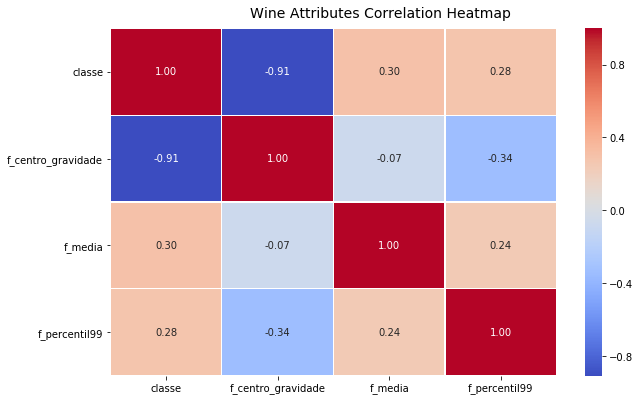

In [33]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

### Exportação

vamos exportar os dados para um CSV. Esse CSV será o nosso dataset de fato, que usaremos em outro arquivo para treinar a MLP.

In [62]:
diretorio = "csv"

if not os.path.exists(diretorio):
    os.makedirs(diretorio)
    
nome = nome_diferente("audiocomandos",diretorio, formato="csv")

tabela.to_csv(nome, index=False)